In [1]:
import numpy as np
import numdifftools as nd
from scipy import optimize, stats
import matplotlib.pyplot as plt

https://stackoverflow.com/questions/77956010/understanding-how-to-extract-error-deviation-from-covariance-matrix-pcov-in-cu

In [2]:
def model(x, a, b, c):
    return a * x + b / (x**2 + 1) + c

In [25]:
np.random.seed(123456)
x = np.linspace(-1, 1, 20)
p = (3, 2, 1)
y = model(x, *p)
sigma = 0.15
s = np.full_like(y, sigma)
n = s * np.random.normal(size=y.size)
y += n

In [26]:
popt, pcov = optimize.curve_fit(model, x, y, sigma=s, absolute_sigma=True)

In [27]:
popt, pcov

(array([3.01353034, 1.92219962, 1.01378869]),
 array([[ 3.05357145e-03,  7.04390835e-11, -6.30392759e-11],
        [ 7.04390835e-11,  3.92488970e-02, -3.02487191e-02],
        [-6.30392759e-11, -3.02487191e-02,  2.44373750e-02]]))

In [28]:
def variance(model, x, p, Cp):
    
    def proxy(q):
        return model(x, *q)
    
    def projection(J):
        return J @ Cp @ J.T
    
    Jp = nd.Gradient(proxy)(p)
    Cy = np.apply_along_axis(projection, 1, Jp)
    
    return Cy

In [29]:
xlin = np.linspace(x.min(), x.max(), 200)
yref = model(xlin, *p)
yhat = model(xlin, *popt)

In [30]:
alpha = 0.01
z = stats.norm.ppf(1 - alpha / 2.)
Cy = variance(model, xlin, popt, pcov)
sy = np.sqrt(Cy)
ci = z * sy

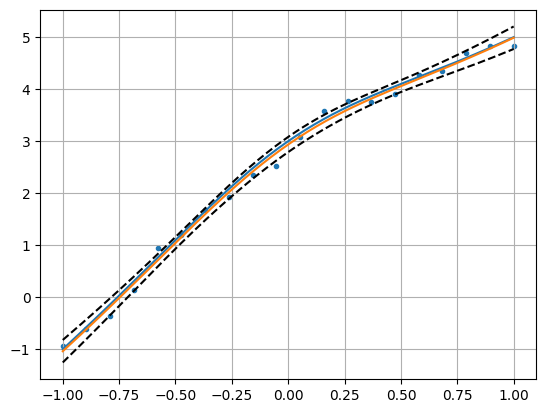

In [31]:
fig, axe = plt.subplots()
axe.scatter(x, y, marker=".")
axe.plot(xlin, yref)
axe.plot(xlin, yhat)
axe.plot(xlin, yhat + ci, "--", color="k")
axe.plot(xlin, yhat - ci, "--", color="k")
axe.grid()

In [45]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF()
regressor = GaussianProcessRegressor(kernel=kernel, alpha=sigma**2)
regressor.fit(x.reshape(-1, 1), y)

GaussianProcessRegressor(alpha=0.0225, kernel=1**2 * RBF(length_scale=1))

In [46]:
ypred, ystd = regressor.predict(xlin.reshape(-1, 1), return_std=True)

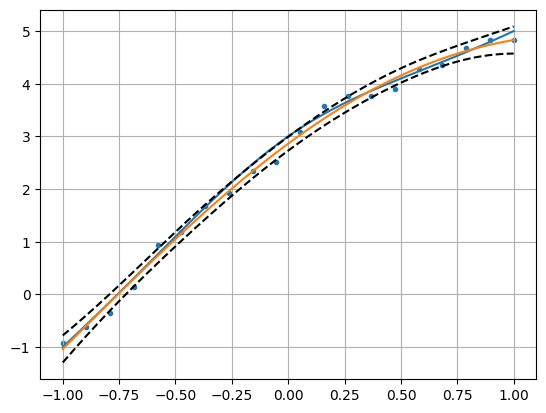

In [47]:
fig, axe = plt.subplots()
axe.scatter(x, y, marker=".")
axe.plot(xlin, yref)
axe.plot(xlin, ypred)
axe.plot(xlin, ypred + z * ystd, "--", color="k")
axe.plot(xlin, ypred - z * ystd, "--", color="k")
axe.grid()